In [ ]:
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt


def read_dcm_images(img_path: str) -> np.array:
    dcm_file = pydicom.read_file(img_path)
    return dcm_file.pixel_array


def plot_img(img, title="Image", cmap="gray"):
    """Plots an image using OpenCV and Matplotlib.

    Args:
        img: OpenCV image (grayscale or color).
        title: Optional title for the plot.
        cmap: Optional colormap for grayscale images.
    """

    # Convert BGR to RGB if necessary
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create the plot using Matplotlib
    plt.figure(figsize=(8, 6))  # Set a default figure size
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")  # Remove axis labels
    plt.show()


def find_roi_bbox_around_centers(contours, img_shape, sort_roi=False):
    # Get the center of the image
    center_x, center_y = img_shape[1] // 2, img_shape[0] // 2
    approx_start_x, approx_start_y = 0.35 * center_x, 0.45 * center_y

    # Initialize variables for top-left and bottom-right corners around the center
    centered_top_left_min = (float('inf'), float('inf'))
    centered_bottom_right_max = (0, 0)

    if sort_roi:
        sorted(contours, key=cv2.contourArea, reverse=True)

    # Loop through each contour and update the top-left and bottom-right corners around the center
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Check if the contour is around the center of the image
        if center_x - approx_start_x < x < center_x + approx_start_x // 2 \
            and center_y - approx_start_y < y < center_y + approx_start_y:
            # Update the top-left corner around the center
            centered_top_left_min = (min(centered_top_left_min[0], x), min(centered_top_left_min[1], y))
            # Update the bottom-right corner around the center
            centered_bottom_right_max = (max(centered_bottom_right_max[0], x + w), max(centered_bottom_right_max[1], y + h))
    return centered_top_left_min[0], centered_top_left_min[1], centered_bottom_right_max[0], centered_bottom_right_max[1]


def is_contour_inside_roi(contour, roi_area) -> bool:
    # Your contour and bounding box
    bbox = cv2.boundingRect(contour)
    # Extract the coordinates of the bounding box
    x, y, width, height = bbox

    x1_roi, y1_roi, x2_roi, y2_roi = roi_area

    # Check if the bounding box is completely inside the specified bounding box
    is_inside = (x1_roi<= x <= x2_roi and
                y1_roi <= y <= y2_roi and
                x1_roi+ width <= x2_roi and
                y1_roi + height <= y2_roi)
    return is_inside

In [ ]:
def find_otsu_thresholding(image, is_normalized=False, bins_num=256):
    # Get the image histogram
    hist, bin_edges = np.histogram(image, bins=bins_num)
    
    # Get normalized histogram if it is required
    if is_normalized:
        hist = np.divide(hist.ravel(), hist.max())
    
    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)
    
    threshold = bin_mids[:-1][index_of_max_val]
    return threshold


def image_segmentation_using_otsu_threshold(image, offset=110):
    if len(image.shape) > 2:
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Check dark points. Take out pixel value < 5
    mask = (image > 5).astype(np.uint8) * 255

    # otsu thresholding
    otsu_threshold = find_otsu_thresholding(image)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(image, offset + otsu_threshold, 255, cv2.THRESH_BINARY)
    print(otsu_threshold)
    segmented_image = cv2.bitwise_and(segmented_image, segmented_image, mask)
    return segmented_image

In [6]:
def predict_tumor_segmentation(image, **kwargs):
    segmented_image = image_segmentation_using_otsu_threshold(image, **kwargs)
    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted(contours, key=cv2.contourArea, reverse=True)
    roi_area = find_roi_bbox_around_centers(contours, image.shape, sort_roi=False)

    contours_inside_roi = []
    contours_inside_roi_mask = np.zeros_like(segmented_image)
    is_tumor_detected = False

    for contour in contours:
        if is_contour_inside_roi(contour, roi_area):
            contours_inside_roi.append(contour)
            cv2.drawContours(contours_inside_roi_mask, [contour], 0, 255, thickness=cv2.FILLED)
            if not is_tumor_detected:
                is_tumor_detected = True

    # Apply the filled mask to the original image
    result_image = np.copy(image)  # Make a copy of the original image

    # You can also draw a rectangle around all contours if needed
    cv2.rectangle(result_image, (roi_area[0], roi_area[1]), (roi_area[2], roi_area[3]), (0, 255, 0), 2)
    result_image[contours_inside_roi_mask == 255] = (255, 0, 0)  # Set the filled region to a specific color (e.g., red)
    return is_tumor_detected, contours_inside_roi, contours_inside_roi_mask, result_image


def calculate_roi_size(segmented_image):
    # Assuming segmented_image is your segmented image
    height, width = segmented_image.shape[:2]

    # Create a binary mask for pixels with value 255
    mask_255 = (segmented_image == 255).astype(np.uint8)

    # Calculate the total area with pixel value 255
    total_area_255 = np.sum(mask_255)
    return total_area_255

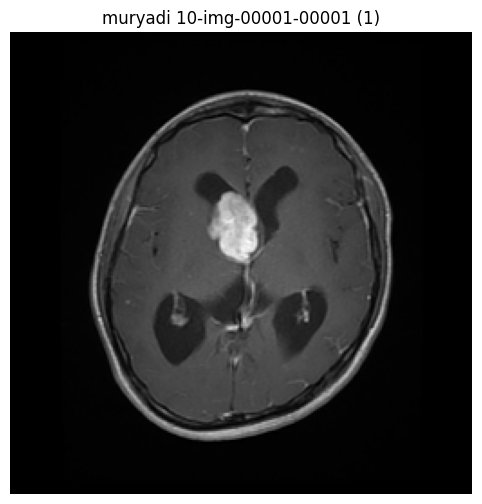

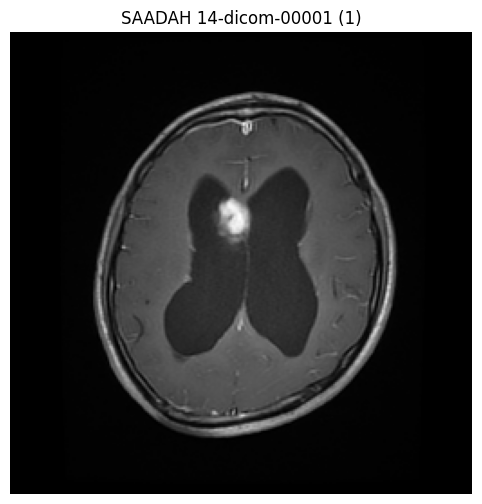

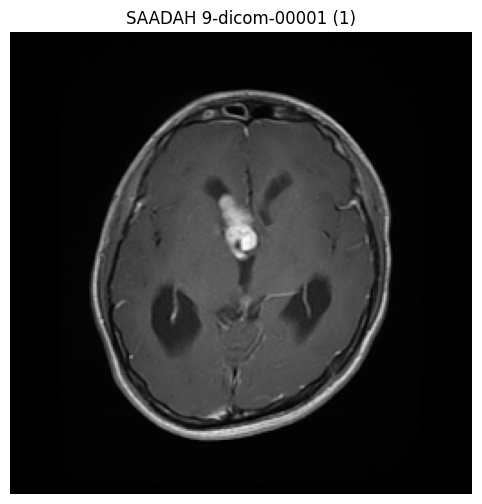

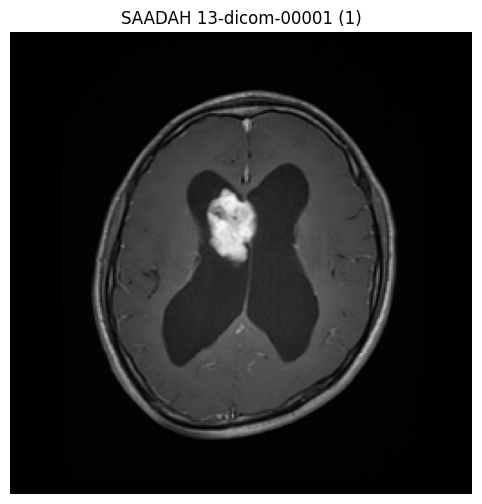

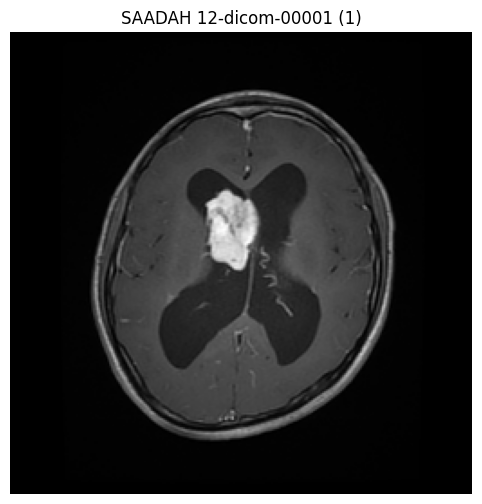

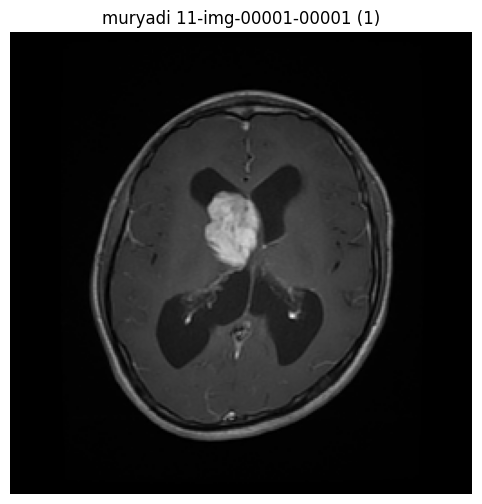

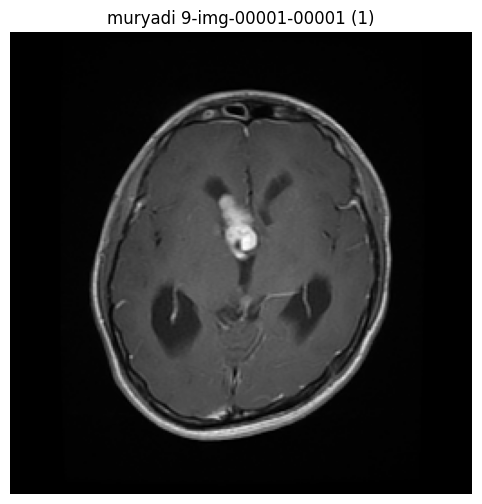

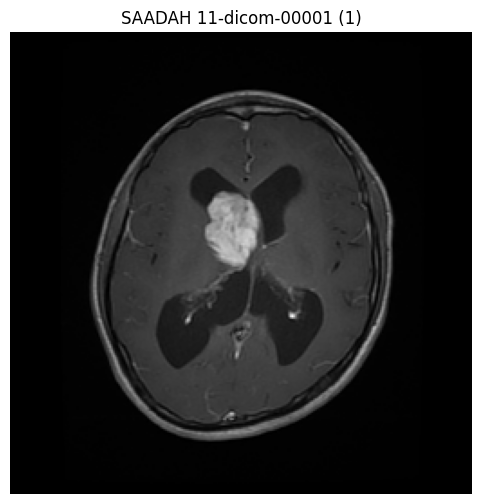

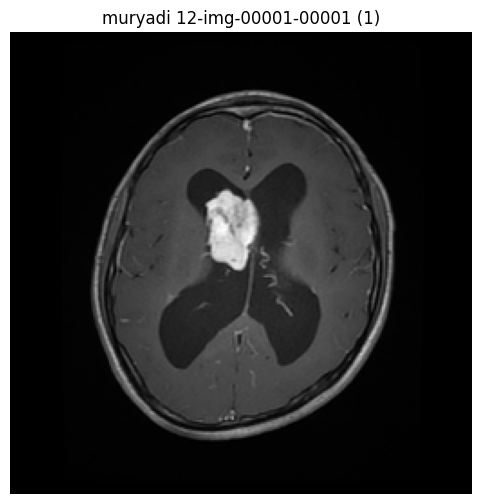

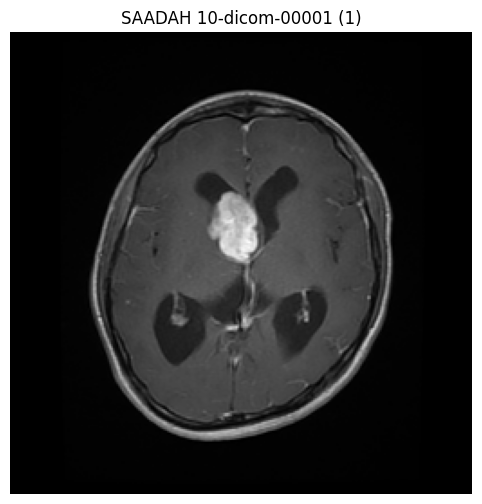

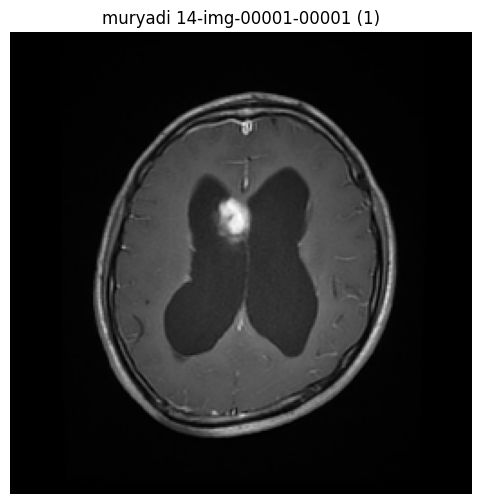

In [7]:
import glob
import os

DATASET_DIR = "dataset/"
list_read_img = []
list_img_names = []

for img_path in glob.glob(os.path.join(DATASET_DIR,"*")):
    img_ext = img_path.split(".")[-1]
    img_name = os.path.split(img_path)[-1].split(".")[0]
    list_img_names.append(f"{img_name}.{img_ext}")
    # print(img_name)
    img = None
    if img_ext == "dcm":
        img = read_dcm_images(img_path)
    else:
        img = cv2.imread(img_path)
    list_read_img.append(img)
    plot_img(img, title=img_name)

41.337890625


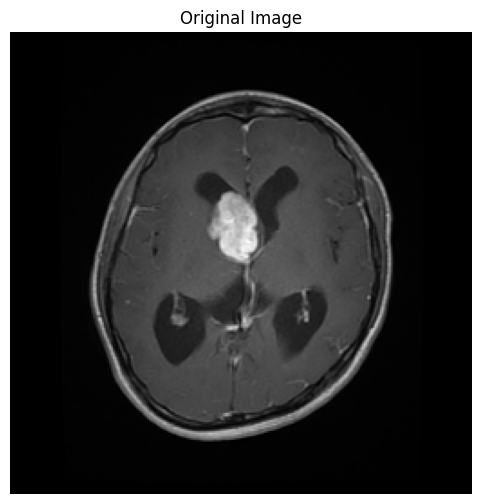

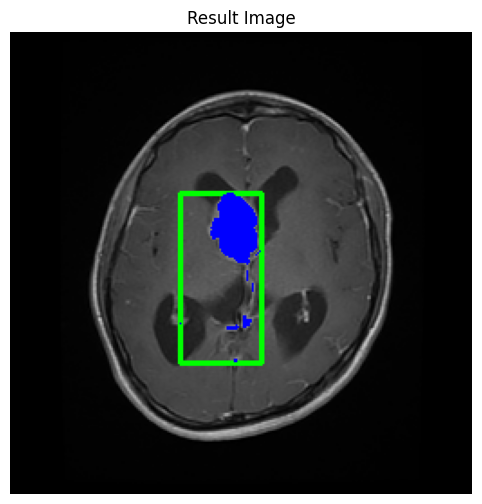

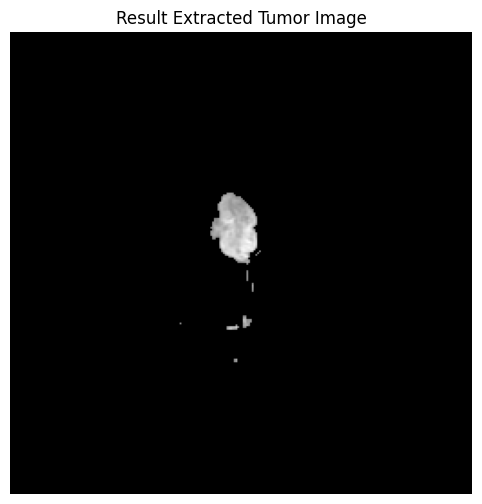

41.337890625


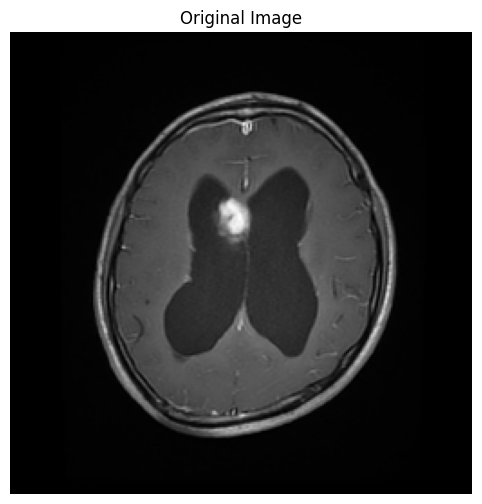

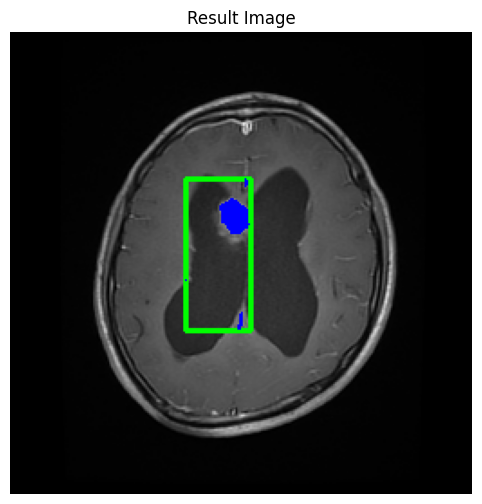

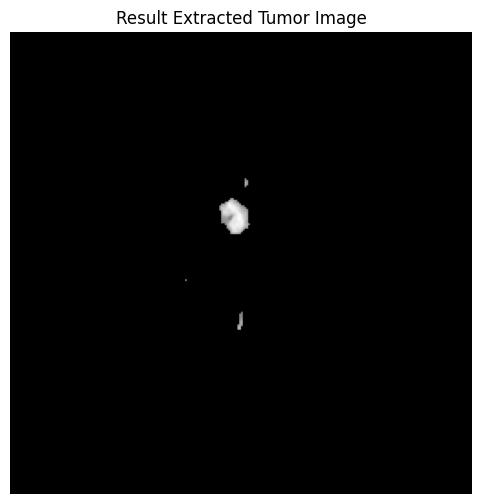

43.330078125


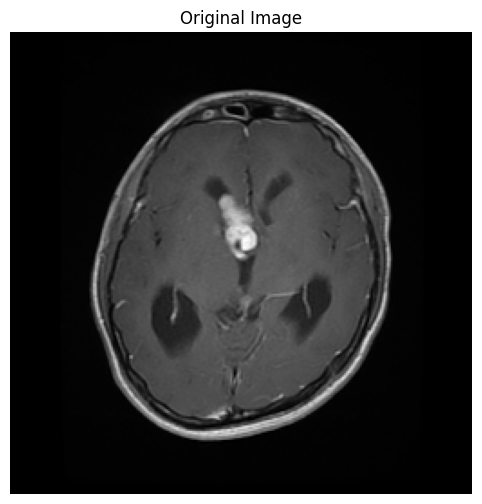

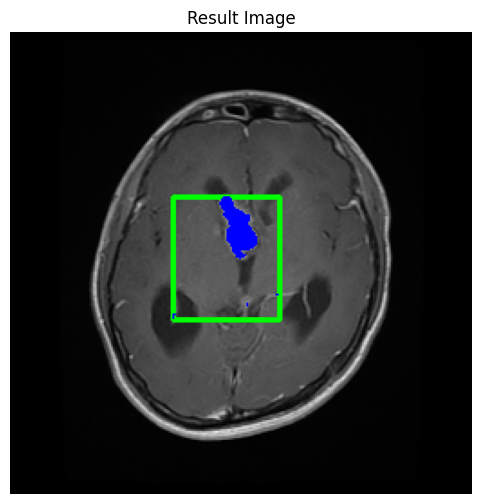

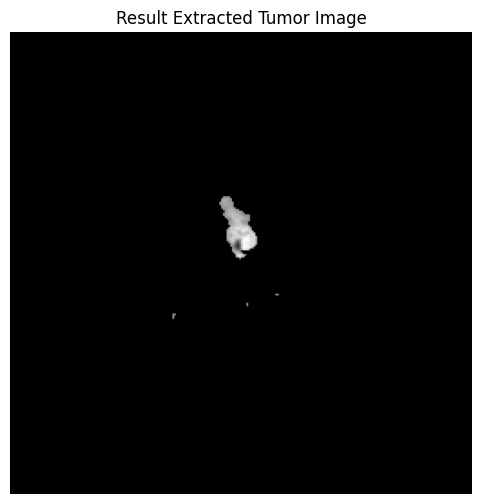

38.349609375


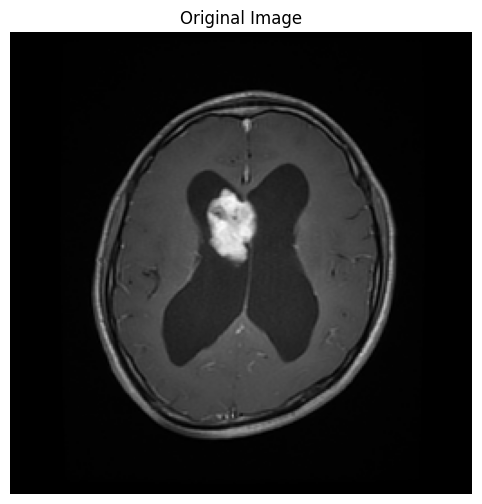

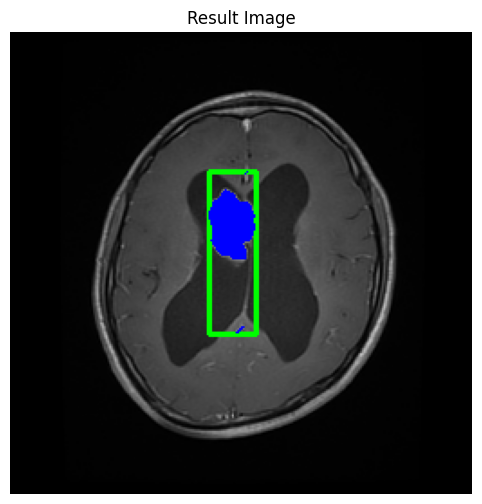

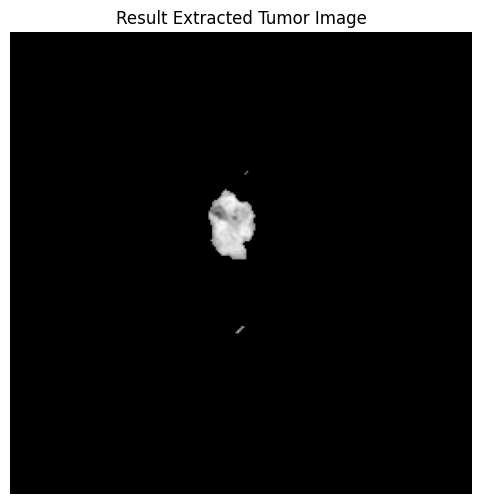

40.341796875


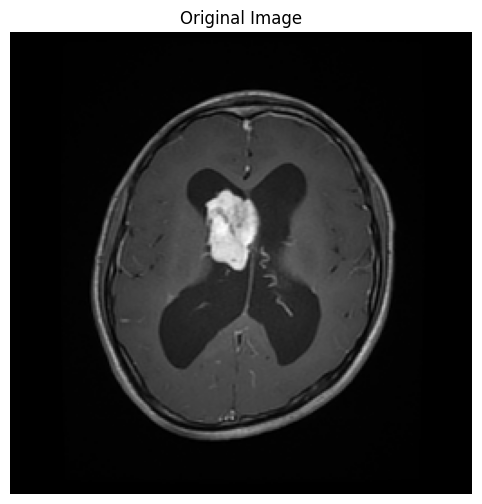

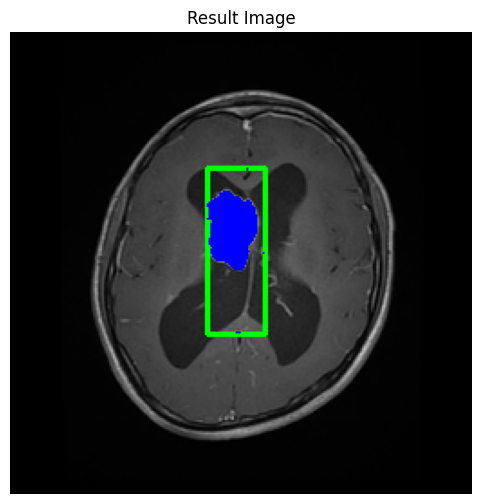

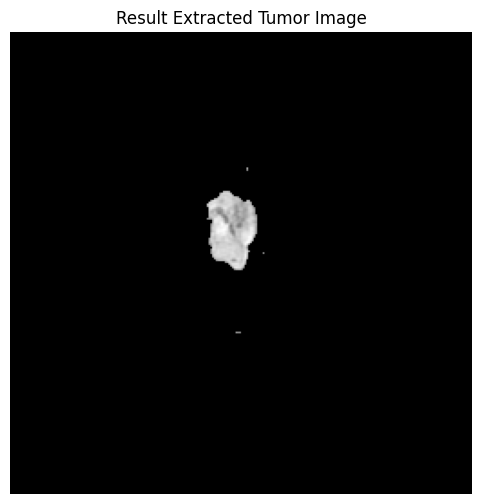

35.361328125


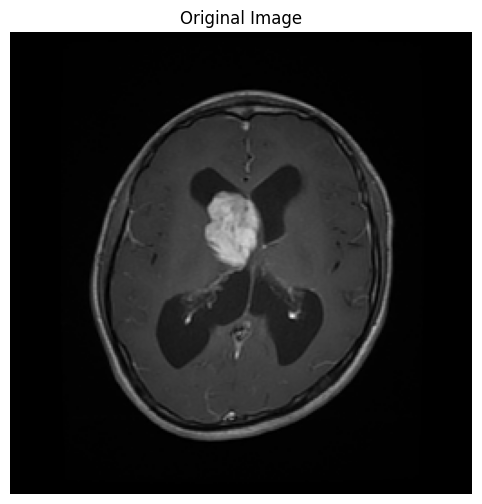

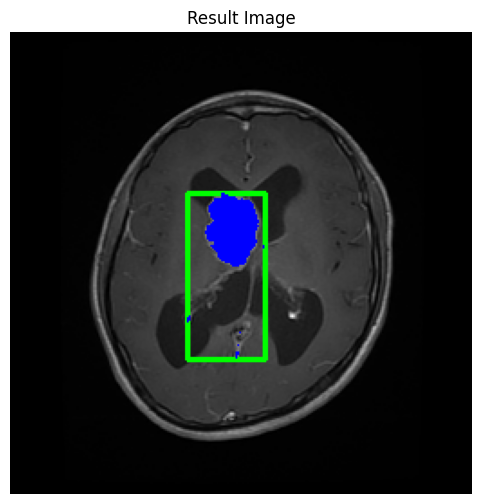

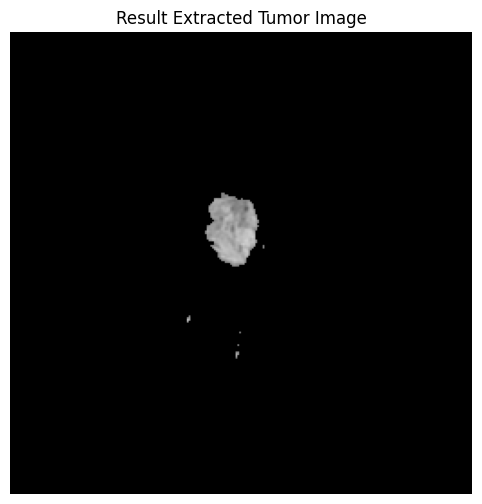

43.330078125


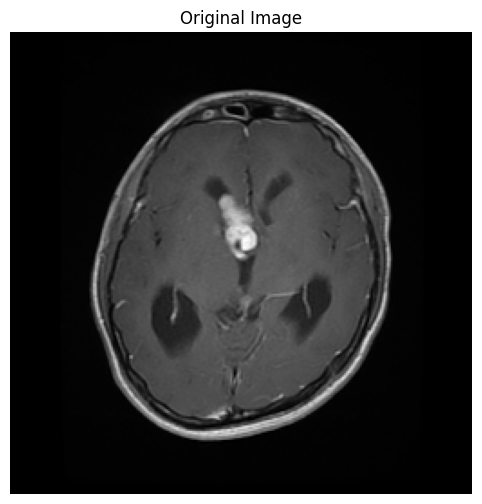

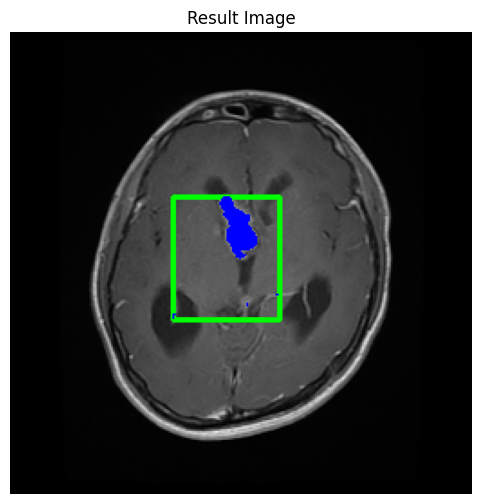

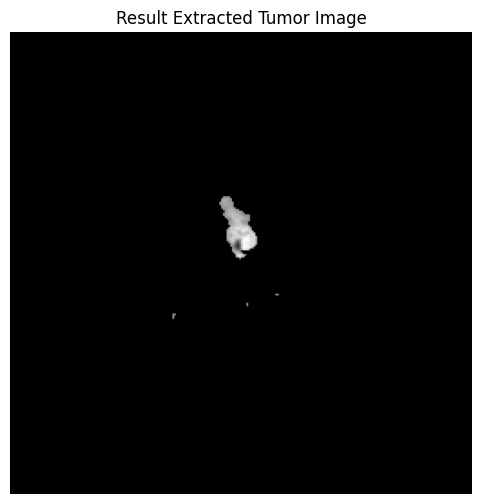

35.361328125


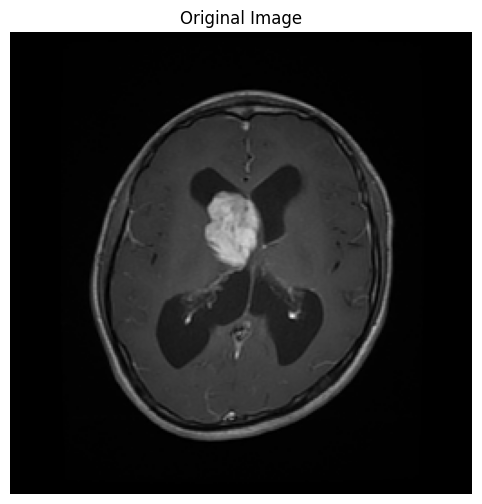

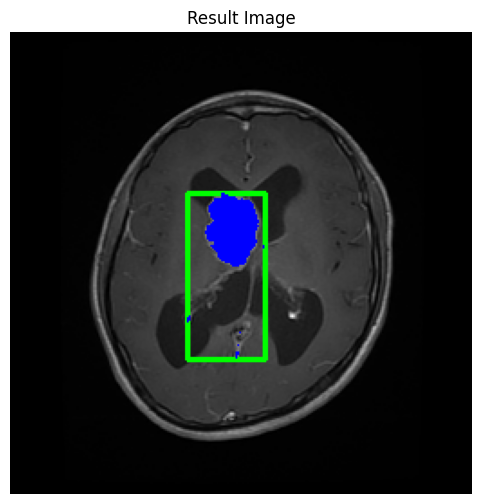

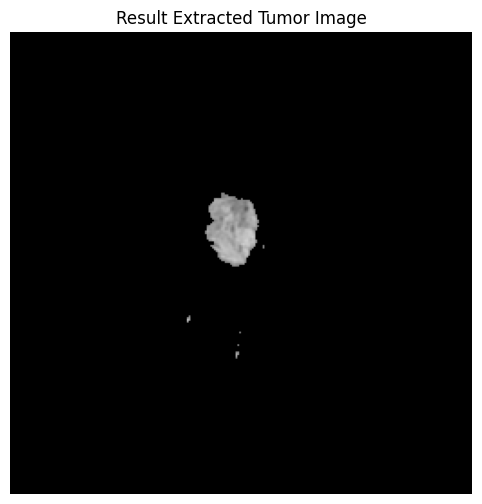

40.341796875


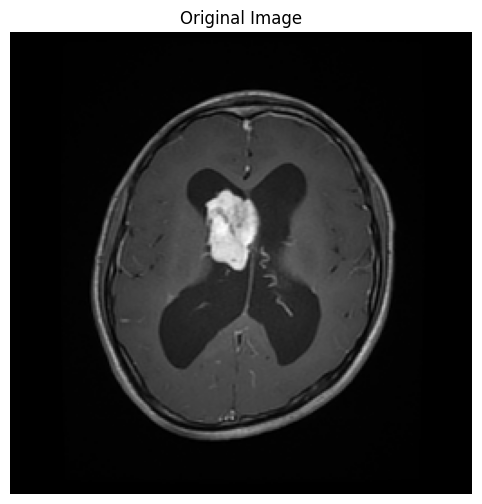

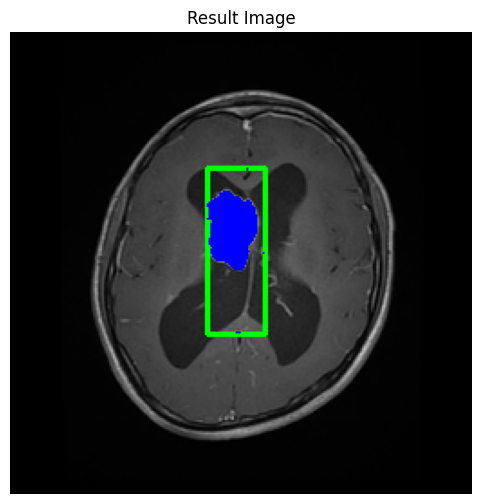

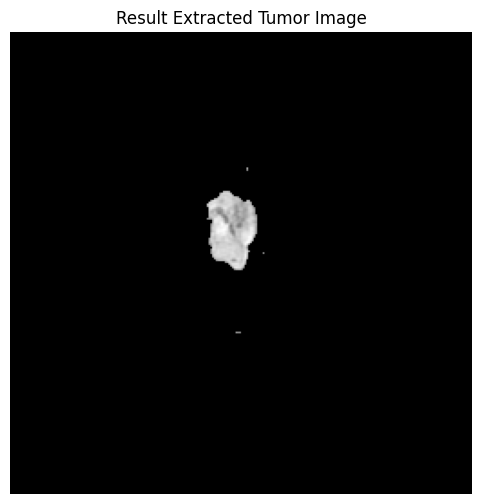

41.337890625


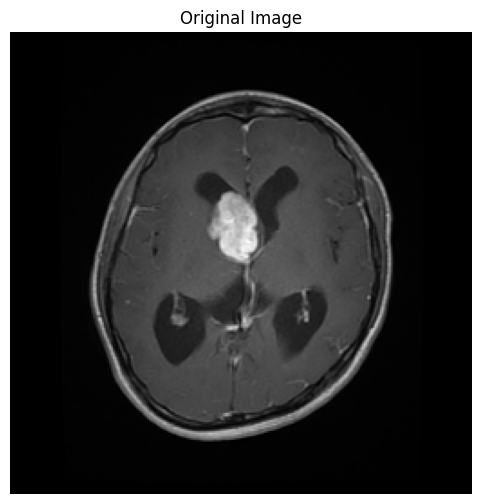

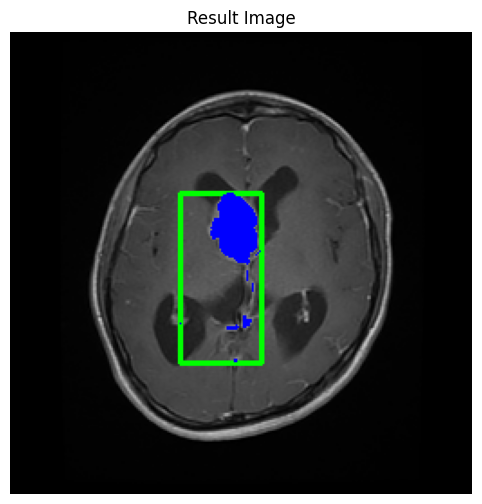

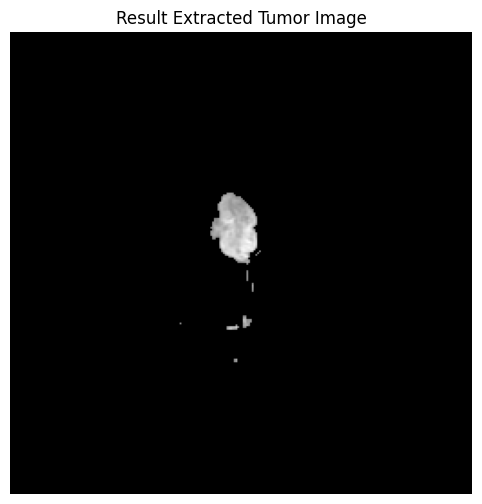

41.337890625


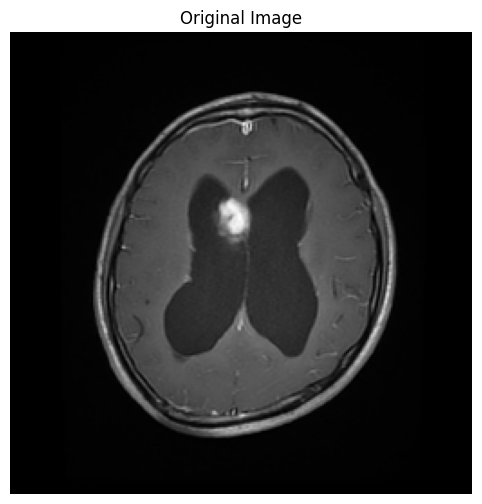

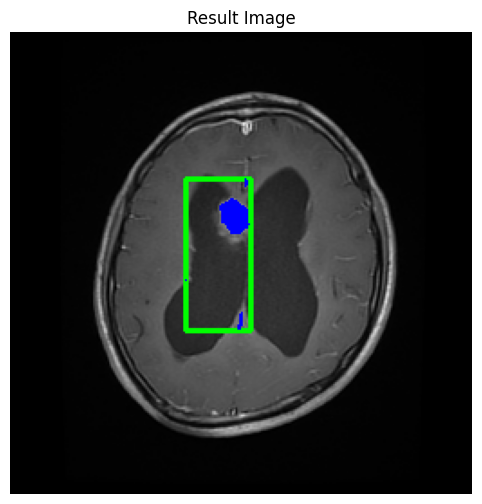

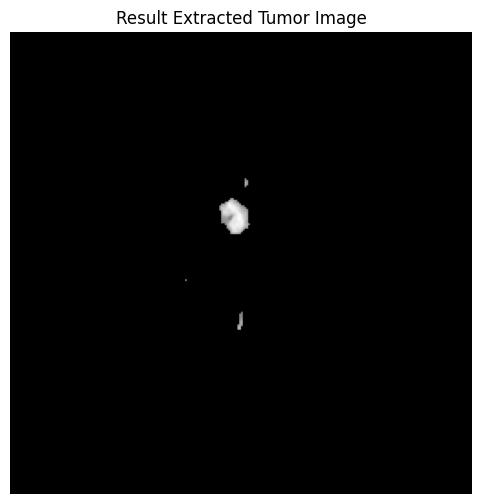

In [8]:
result_tumor_prediction = []
result_tumor_size = []
kwargs = {
    "offset": 90
}
for img_name, img in zip(list_img_names, list_read_img):
    is_tumor_detected, _, contours_inside_roi_mask, result_image = predict_tumor_segmentation(img, **kwargs)
    is_tumor_detected = 1 if is_tumor_detected else 0
    result_tumor_prediction.append(is_tumor_detected)
    #Extract the tumor image from the original image
    extracted_tumor_img = cv2.bitwise_and(img, img, mask=contours_inside_roi_mask)
    result_tumor_size.append(calculate_roi_size(contours_inside_roi_mask))
    plot_img(img, title=f"Original Image")
    plot_img(result_image, title=f"Result Image")
    plot_img(extracted_tumor_img, title="Result Extracted Tumor Image")

In [9]:
import pandas as pd

df = pd.DataFrame(
    {"Filename": list_img_names, "Result Prediction": result_tumor_prediction, "Total area size (px)": result_tumor_size}
)
df

,Filename,Result Prediction,Total area size (px)
0,muryadi 10-img-00001-00001 (1).bmp,1,775
1,SAADAH 14-dicom-00001 (1).dcm,1,265
2,SAADAH 9-dicom-00001 (1).dcm,1,387
3,SAADAH 13-dicom-00001 (1).dcm,1,727
4,SAADAH 12-dicom-00001 (1).dcm,1,909
5,muryadi 11-img-00001-00001 (1).bmp,1,881
6,muryadi 9-img-00001-00001 (1).bmp,1,387
7,SAADAH 11-dicom-00001 (1).dcm,1,881
8,muryadi 12-img-00001-00001 (1).bmp,1,909
9,SAADAH 10-dicom-00001 (1).dcm,1,775


In [10]:
df.to_csv("result_prediction.csv", index=False)